In [35]:
import os

#only use GPU 0 
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Force CPU use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorrt
import tensorflow as tf

#If memory growth is enabled for a PhysicalDevice, the runtime initialization will not allocate all memory on the device. 
#https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth
#gpu = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpu[0], True)

In [36]:
import sys
from pathlib import Path
import os
import re
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.io import imread
import sklearn.metrics
from sklearn.metrics import confusion_matrix

import tensorrt
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.activations import relu

In [37]:
HOME = Path('/home/peregrin/Desktop/Louise')

data_base_dir = HOME / 'CNN-main/Input'
Path_to_folder = HOME / 'CNN-main'


In [38]:
IMG_CHANNELS = 3
IMG_WIDTH = 526
IMG_HEIGHT = 526
epochs = 60                    
batchSIZE = 2                   
augment_training_data = True    # Performs flipping and rotations by 90°

data_generator_args = dict(rotation_range=0.5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')


In [39]:
def data_generator(data_frame, batch_size, aug_dict,
                    image_color_mode="rgb",
                    mask_color_mode="grayscale",
                    image_save_prefix="image",
                    mask_save_prefix="mask",
                    save_to_dir=None,
                    target_size=(IMG_CHANNELS, IMG_WIDTH),
                    seed=1,
                    augment:bool=False):

    image_datagen = ImageDataGenerator(**aug_dict)


    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="filename",
        y_col = "label",
        class_mode="sparse",
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed)




    for (img, label) in image_generator:
        #print('Got label', label, ' -- ', img[0, 125, 125,0])
        for _i, _m in adjust_data(img, label, augment):
            yield (_i, _m)


def rescale_data(img):
    """ Rescale images to have float channels \in [0, 1], boolean masks.

    """
    img = img / 255


    return (img)


def augment_data(img, label):
    """ Data augmentation by rotation and flipping.
    """
    images = [img]

    flipped_img = tf.image.flip_up_down(img)
    images.append(flipped_img)

    for i in range(1, 4):
        images.append(tf.image.rot90(img, i))
        images.append(tf.image.rot90(flipped_img, i))

    return zip(images, 8 * [label])


def adjust_data(img, label, augment:bool):
    """ Perform image value scaling and augmentation """
    img = rescale_data(img)

    if not augment:
        return zip([img], [label])

    return augment_data(img, label)

def assign_class(size):
    if size == '0-5 mm':
        return 0
    elif size == '6-9 mm':
        return 1
    elif size == '10-19 mm':
        return 2
    else:
        return 3


In [40]:
#Image folder
folder_images = 'Raw_images'

#image
print('Collecting data from {}:'.format(str(data_base_dir)))
train_files = list((data_base_dir / folder_images).glob('*.png'))

#MASK not used yet
mask_files = list()
for _f in train_files:
    _mf = data_base_dir / str(_f).replace("raw", "segmentation").replace(folder_images, "segmentation_images")
    
    mask_files.append(_mf)
    

print('  … collected {} samples.'.format(len(train_files)))


#Label
os.chdir(Path_to_folder)
df_labels = pd.read_csv('Finished_annotations_depth_information.csv')
label_files = list()

for _f in train_files: 
    filename = os.path.basename(_f)
    parts = filename.split("_")
    patient_id = int(parts[1])
    P_x = parts[2]
    polyp_num = int(P_x[1:])
    
    filter_condition = (df_labels['Patient ID'] == patient_id) & (df_labels['Polyp'] == polyp_num)
    #label_OC = df_labels.loc[filter_condition, 'OC Morphology'].values[0]
    label_value = df_labels.loc[filter_condition, 'class'].values[0]
    label_value = assign_class(label_value)
    
    label_files.append(label_value)
    
print(len(label_files), len(train_files), len(mask_files))


# Splitting the data set
df = pd.DataFrame(data={"filename": [str(_f) for _f in train_files], 'mask': [str(_f) for _f in mask_files], 'label': [str(_f) for _f in label_files]})
df_train, df_test = train_test_split(df, test_size=0.1)
df_train, df_val = train_test_split(df_train, test_size=0.2)

print('Data set statistics:')
print('\tFull data set:  {:8d} samples'.format(len(df)))
print('\tTraining set:   {:8d} samples, {:2.0f} %, to be augmented x8: {}'.format(len(df_train), np.floor(len(df_train)/len(df)*100), augment_training_data))
print('\tValidation set: {:8d} samples, {:2.0f} %'.format(len(df_val), np.floor(len(df_val)/len(df)*100)))
print('\tTest set:       {:8d} samples, {:2.0f} %'.format(len(df_test), np.floor(len(df_test)/len(df)*100)))


#Generate training and validation data from dfs
train_gen = data_generator(df_train, batchSIZE, data_generator_args,
                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                            augment=augment_training_data)


valid_gen = data_generator(df_val, batchSIZE,
                            dict(),
                            target_size=(IMG_HEIGHT, IMG_WIDTH))
test_gen = data_generator(df_test, batchSIZE,
                            dict(),
                            target_size=(IMG_HEIGHT, IMG_WIDTH))

Path_to_save= HOME / 'CNN_model_weights'
os.chdir(Path_to_save)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 30, min_delta = 0.001, restore_best_weights = True)

#Set activation function and optimizers
act = 'relu'
opt = 'adam'

  … collected 235 samples.
235 235 235
Data set statistics:
	Full data set:       235 samples
	Training set:        168 samples, 71 %, to be augmented x8: True
	Validation set:       43 samples, 18 %
	Test set:             24 samples, 10 %


Testing activation functions and optimizers

In [7]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 60, min_delta = 0.001, restore_best_weights = True)

Summary for model with adam optimizer and relu as activation function.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 524, 524, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 262, 262, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 262, 262, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 260, 260, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 130, 130, 32)     0         
 2D)                                                             
                                                   

2023-05-27 17:59:53.413418: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-27 17:59:53.413444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: took
2023-05-27 17:59:53.413450: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: took
2023-05-27 17:59:53.413480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-05-27 17:59:53.413501: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-05-27 17:59:53.413508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


Found 168 validated image filenames belonging to 4 classes.
Epoch 1/60


2023-05-27 17:59:53.774928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - ETA: 0s - loss: 8.0628 - accuracy: 0.4940Found 43 validated image filenames belonging to 4 classes.


2023-05-27 18:00:12.681252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - 20s 333ms/step - loss: 8.0628 - accuracy: 0.4940 - val_loss: 1.3749 - val_accuracy: 0.3953
Epoch 2/60
56/56 [==============================] - 18s 328ms/step - loss: 1.3750 - accuracy: 0.3512 - val_loss: 1.3651 - val_accuracy: 0.3953
Epoch 3/60
56/56 [==============================] - 18s 325ms/step - loss: 1.3645 - accuracy: 0.4226 - val_loss: 1.3498 - val_accuracy: 0.4651
Epoch 4/60
56/56 [==============================] - 18s 324ms/step - loss: 1.3128 - accuracy: 0.3750 - val_loss: 1.3567 - val_accuracy: 0.3488
Epoch 5/60
56/56 [==============================] - 18s 322ms/step - loss: 1.3363 - accuracy: 0.3810 - val_loss: 1.3745 - val_accuracy: 0.3256
Epoch 6/60
56/56 [==============================] - 18s 316ms/step - loss: 1.3804 - accuracy: 0.2857 - val_loss: 1.3423 - val_accuracy: 0.4651
Epoch 7/60
56/56 [==============================] - 18s 316ms/step - loss: 1.3935 - accuracy: 0.3333 - val_loss: 1.3635 - val_accuracy: 0.3721
Epoch 8/60

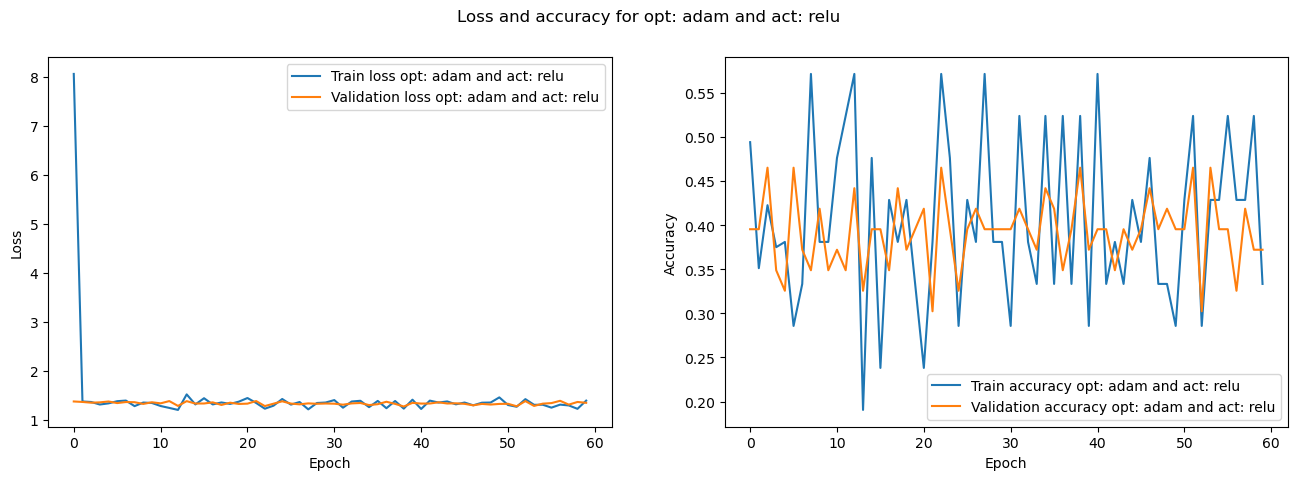

2023-05-27 18:17:43.093721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,262,262,32]
	 [[{{node inputs}}]]
2023-05-27 18:17:43.106112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64,64,64]
	 [[{{node inputs}}]]
2023-05-27 18:17:43.114148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,31,31,64]
	 [[{{node inputs}}]]

INFO:tensorflow:Assets written to: model_relu/assets


INFO:tensorflow:Assets written to: model_relu/assets


In [8]:
opt = 'adam'
act='relu'


model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=act,
                               input_shape=(526, 526, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=act),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=act),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation = act),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=act),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation=act),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation=act),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

model.compile(
            optimizer=opt,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'],
            )

print(f'Summary for model with {opt} optimizer and {act} as activation function.')
model.summary()
history= model.fit(train_gen,
                                steps_per_epoch=len(df_train) / batchSIZE,
                                epochs=epochs, 
                                validation_data=valid_gen,
                                validation_steps=len(df_val) / batchSIZE, verbose=1)
        
fig = plt.figure(figsize = plt.figaspect(0.3))
fig.suptitle('Loss and accuracy for opt: ' + opt+ ' and act: ' + act)
        
ax = fig.add_subplot(1,2,1)
ax.plot(history.history['loss'], label='Train loss opt: '+opt+ ' and act: '+act)
ax.plot(history.history['val_loss'], label = 'Validation loss opt: '+opt+ ' and act: '+act)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


ax = fig.add_subplot(1,2,2)
ax.plot(history.history['accuracy'], label='Train accuracy opt: '+opt+' and act: '+act)
ax.plot(history.history['val_accuracy'], label = 'Validation accuracy opt: '+opt+' and act: '+act)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

Path_to_save= HOME / 'CNN_model_weights'
os.chdir(Path_to_save)

model.save('model_relu')



Summary for model with adam optimizer and relu as activation function.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 524, 524, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 262, 262, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 262, 262, 32)      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 260, 260, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 130, 130, 32)     0         
 2D)                                                             
                                                 

2023-05-27 18:20:54.466812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - ETA: 0s - loss: 1.4054 - accuracy: 0.3571

2023-05-27 18:21:12.793847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - 19s 325ms/step - loss: 1.4054 - accuracy: 0.3571 - val_loss: 1.3682 - val_accuracy: 0.3953
Epoch 2/60
56/56 [==============================] - 18s 318ms/step - loss: 1.4486 - accuracy: 0.4286 - val_loss: 1.3676 - val_accuracy: 0.4186
Epoch 3/60
56/56 [==============================] - 18s 315ms/step - loss: 1.3572 - accuracy: 0.2917 - val_loss: 1.3773 - val_accuracy: 0.4419
Epoch 4/60
56/56 [==============================] - 18s 314ms/step - loss: 1.3221 - accuracy: 0.3452 - val_loss: 1.3829 - val_accuracy: 0.3488
Epoch 5/60
56/56 [==============================] - 17s 310ms/step - loss: 1.3929 - accuracy: 0.2798 - val_loss: 1.3765 - val_accuracy: 0.4419
Epoch 6/60
56/56 [==============================] - 17s 311ms/step - loss: 1.3607 - accuracy: 0.5298 - val_loss: 1.3792 - val_accuracy: 0.3023
Epoch 7/60
56/56 [==============================] - 18s 313ms/step - loss: 1.3685 - accuracy: 0.3393 - val_loss: 1.3411 - val_accuracy: 0.4884
Epoch 8/60

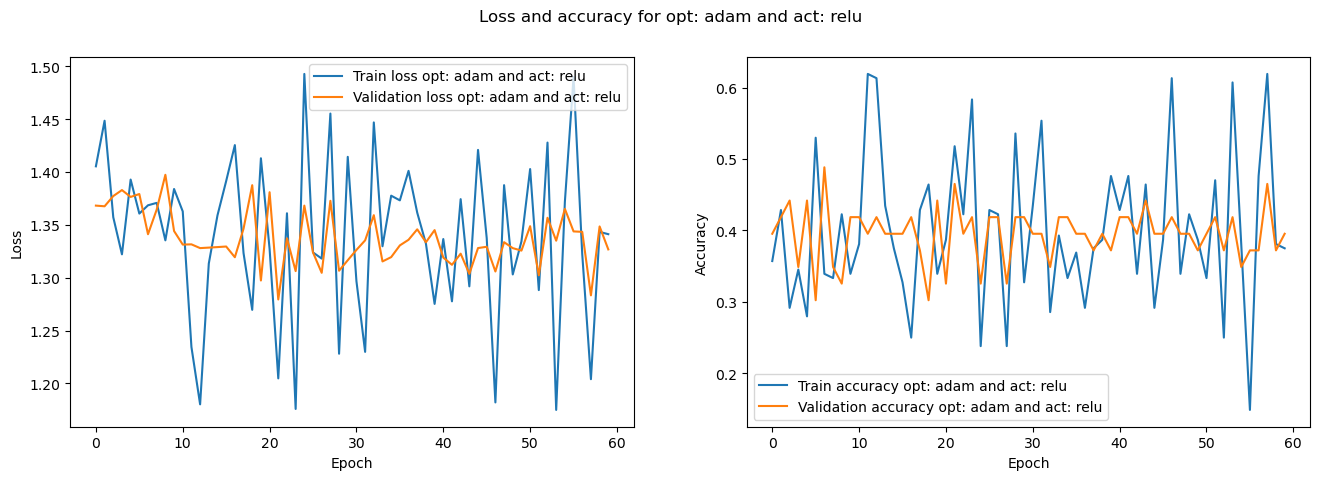

2023-05-27 18:38:23.178944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,262,262,32]
	 [[{{node inputs}}]]
2023-05-27 18:38:23.190744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64,64,64]
	 [[{{node inputs}}]]
2023-05-27 18:38:23.198915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,31,31,64]
	 [[{{node inputs}}]]

INFO:tensorflow:Assets written to: model_tanh/assets


INFO:tensorflow:Assets written to: model_tanh/assets


In [9]:
optimizers = 'adam'
activations = 'tanh'


model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=act,
                               input_shape=(526, 526, 3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=act),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=act),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation = act),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=act),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation=act),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(32, activation=act),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

model.compile(
            optimizer=opt,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'],
            )

print(f'Summary for model with {opt} optimizer and {act} as activation function.')
model.summary()
history= model.fit(train_gen,
                                steps_per_epoch=len(df_train) / batchSIZE,
                                epochs=epochs, 
                                validation_data=valid_gen,
                                validation_steps=len(df_val) / batchSIZE, verbose=1)
        
fig = plt.figure(figsize = plt.figaspect(0.3))
fig.suptitle('Loss and accuracy for opt: ' + opt+ ' and act: ' + act)
        
ax = fig.add_subplot(1,2,1)
ax.plot(history.history['loss'], label='Train loss opt: '+opt+ ' and act: '+act)
ax.plot(history.history['val_loss'], label = 'Validation loss opt: '+opt+ ' and act: '+act)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


ax = fig.add_subplot(1,2,2)
ax.plot(history.history['accuracy'], label='Train accuracy opt: '+opt+' and act: '+act)
ax.plot(history.history['val_accuracy'], label = 'Validation accuracy opt: '+opt+' and act: '+act)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

Path_to_save= HOME / 'CNN_model_weights'
os.chdir(Path_to_save)

model.save('model_tanh')


 Evaluation of these models

In [41]:

test_gen = data_generator(df_test, batchSIZE,
                            dict(),
                            target_size=(IMG_HEIGHT, IMG_WIDTH))

In [42]:
modelrelu= tf.keras.models.load_model('/home/peregrin/Desktop/Louise/CNN_model_weights/model_relu')
modelrelu.evaluate(test_gen, steps=len(df_test)/batchSIZE, verbose=1)

Found 24 validated image filenames belonging to 4 classes.
 3/12 [======>.......................] - ETA: 0s - loss: 1.5550 - accuracy: 0.1667    

2023-05-29 06:37:00.532955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 0s 31ms/step - loss: 1.3590 - accuracy: 0.3750


[1.3590461015701294, 0.375]

In [44]:
modeltanh= tf.keras.models.load_model('/home/peregrin/Desktop/Louise/CNN_model_weights/model_tanh')
modeltanh.evaluate(test_gen, steps=len(df_test)/batchSIZE, verbose=1)

 1/12 [=>............................] - ETA: 1s - loss: 1.5741 - accuracy: 0.0000e+00

2023-05-29 06:37:23.885546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12/12 [==============================] - 1s 31ms/step - loss: 1.3536 - accuracy: 0.3750


[1.353577971458435, 0.375]